# Neural networks with PyTorch

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL. Copyright (c) 2021 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** [David Mizrahi](mailto:david.mizrahi@epfl.ch)
<hr style="clear:both">


In this exercise, we'll cover the basics of the [PyTorch](https://pytorch.org) package and use it to implement a simple neural network.

## Installation

If you're running this notebook locally, you'll first need to install PyTorch and torchvision. You can do so by following the instructions at: https://pytorch.org/get-started/locally/. Make sure to install these packages in the `introml` environment created for this course.

If you're using Google Colab or EPFL Noto, PyTorch should already be installed. You can check by trying to import the package with `import torch`.

In [1]:
# Verify that PyTorch and torchvision are installed correctly
# Note: You may need to restart your kernel and re-run this cell before running the following cells

import torch
import torchvision

In [2]:
torch.__version__

'2.0.0'

In [3]:
torchvision.__version__

'0.15.0'

#### For Google Colab
You can run this notebook in Google Colab using the following link: https://colab.research.google.com/github/vita-epfl/introML-2023/blob/main/exercises/06-neural-nets/neural_nets_pytorch.ipynb

In [4]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  # Clone the entire repo to access the files
  !git clone -l -s https://github.com/vita-epfl/introML-2023.git cloned-repo
  %cd cloned-repo/exercises/06-neural-nets/

# Exercise 1: Deep Learning with PyTorch: A 60 Minute Blitz

PyTorch's website offers an excellent tutorial on the basics of PyTorch, which can be found  at the following link: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

We heavily recommend completing this tutorial before moving on to the second exercise.

# Exercise 2: Simple neural nets with PyTorch

In this exercise, we'll implement classifiers with PyTorch.
More specifically, we'll compare a simple logistic regression model to a simple neural network on the MNIST dataset.

Here is the general pipeline used to train neural networks with PyTorch:

```
1. Load the dataset
2. Initialize a dataloader, define data transforms
3. Define and instantiate network architecture
4. Choose a loss function
5. Choose an optimizer (incl. learning rate, weight decay & momentum)
6. Define the training loop & number of epochs
7. Train the model
8. Check validation accuracy, visualize results, adjust hyper-parameters (not done in this exercise)
9. Repeat steps 2-9 until satisfied with validation accuracy (not done in this exercise)
10. Check test accuracy
```

*Epoch: number of times that the learning algorithm will work through the entire training set*

In this exercise, we'll follow these steps to implement our classifiers. Let's get started!

## 1. Imports

In [5]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST

# Progress bar
from tqdm.auto import tqdm

# Helper files
import helpers
import metrics

Here is a brief description of these imported packages:

**PyTorch:**
- `torch.nn` Contains the basic building blocks to implement neural nets (incl. different types of layers and loss functions) | [Documentation](https://pytorch.org/docs/stable/nn.html)
- `torch.nn.functional` A functional (stateless) approach to torch.nn, often used for stateless objects (e.g. ReLU) | [Documentation](https://pytorch.org/docs/stable/nn.functional.html) | [More info](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/2)
- `torch.optim` A package implementing various optimization algorithms, such as SGD and Adam | [Documentation](https://pytorch.org/docs/stable/optim.html)

**torchvision:**
- `torchvision.transforms` Common image transformations
- `torchvision.datasets` Popular image datasets

**`tqdm`:** Popular package used to show progress bars | [Documentation](https://tqdm.github.io/)

**`helpers`**: Contains functions to help visualize data and predictions

**`metrics`:** Contains two simple classes that help keep track and compute the loss and accuracy over a training epoch

## 2. Loading and visualizing the data

### 2.1. Dataset

Here, we'll use the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which consists of black-and-white 28x28  images of hand-drawn digits (between 0 and 9). 
The training set has 60,000 examples, and the test set 10,000 examples.

The `torchvision` package provides an easy way to load this dataset (among many others). 

A list of datasets that can be loaded this way can be found at: https://pytorch.org/docs/stable/torchvision/datasets.html

In [7]:
# Save dataset in a folder called "/data"
root = "data/"

# transforms.ToTensor() is used to convert the downloaded PIL Image to a torch Tensor
train_data = MNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST(root, train=False, transform=transforms.ToTensor(), download=True)

In [8]:
print(f"Images in training data: {len(train_data)}")
print(f"Images in test data: {len(test_data)}")

Images in training data: 60000
Images in test data: 10000


In [9]:
# Show the mapping from target value to class name (if you're using MNIST, you won't be too surprised)
{i: class_name for i, class_name in enumerate(train_data.classes)}

{0: '0 - zero',
 1: '1 - one',
 2: '2 - two',
 3: '3 - three',
 4: '4 - four',
 5: '5 - five',
 6: '6 - six',
 7: '7 - seven',
 8: '8 - eight',
 9: '9 - nine'}

### 2.2. Dataloader

When training neural networks, we usually use mini-batches of data for each forward + backward pass. 

In order to obtain those mini-batches, we must pass our dataset through `torch.utils.DataLoader`, which combines the dataset and a sampler, and returns an iterable over the data and labels of our dataset.

In this exercise, we'll pick a batch size of 32.

In [10]:
batch_size = 32
# Reshuffle training data at every epoch, but not the test data 
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Let's take a look at one of our batches.

In [11]:
images, targets = next(iter(train_loader))

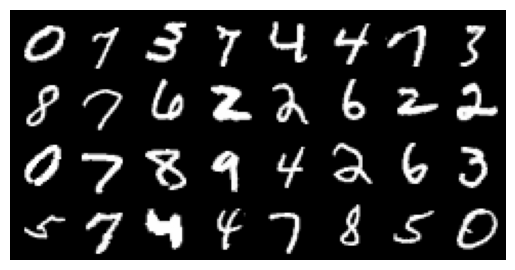

tensor([[0, 7, 3, 7, 4, 4, 7, 3],
        [8, 7, 6, 2, 2, 6, 2, 2],
        [0, 7, 8, 9, 4, 2, 6, 3],
        [5, 7, 4, 4, 7, 8, 5, 0]])


In [12]:
helpers.imshow(torchvision.utils.make_grid(images, nrow=8))
print(targets.reshape(-1, 8))

## 3. Simple model

First, we'll build a simple classifier (akin to logistic regression).

###  3.1 Network architecture

#### Short primer on `nn.Module`

In PyTorch, each neural net architecture is a subclass of `nn.Module` ([Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html))

To quote an [official tutorial](https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html?highlight=module):

> All network components should inherit from `nn.Module` and override the `forward()` method. That is about it, as far as the boilerplate is concerned. Inheriting from `nn.Module` provides functionality to your component. For example, it makes it keep track of its trainable parameters, you can swap it between CPU and GPU with the `.to(device)` method, where device can be a CPU device `torch.device("cpu")` or CUDA device `torch.device("cuda:0")`.


In order to implement your model, you'll therefore need to fill in two methods:

**`__init__()`**: 

- Initialize your layers here, so that the module can keep track of these layers' parameters. 
- It is not necessary to initialize layers with no learnable parameters (e.g. `ReLU`), as you can use  the`nn.functional` API for those if you want.

**`forward()`**:

- Define your model architecture here (i.e. call your layers in the desired order). You can use any of the Tensor operations in the `forward` function.
- This function defines the computation performed at every call. The backward function (where gradients are computed) is automatically defined for you using autograd. 

The learnable parameters of a model are returned by `model.parameters()`.

#### One layer neural net

You should implement a one-layer network composed of the following:
- A layer that flattens the image (already implemented)
- A fully-connected layer from the flattened input of shape (784,) to the output layer of shape (10,) as we have 10 different classes.

This one-layer neural network is equivalent to softmax regression. 

You may wonder why there is no softmax layer in this architecture. This is because it is directly added to the [`CrossEntropyLoss()` module](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), which expects raw, unnormalized scores for each class.

As a result, we also added a `predict()` method that adds this softmax layer, it'll be useful later on.

**One layer neural net:**

<img src="images/1_layer_net.png" width=220></img>

In [13]:
class OneLayerNet(nn.Module):
    """1-Layer MNIST classifier"""
    
    def __init__(self):
        super().__init__()
        ### START CODE HERE ###
        self.fc = nn.Linear(784, 10)
        
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)
        ### START CODE HERE ###
        out = self.fc(x)
        
        return out
        ### END CODE HERE ###
  
    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = OneLayerNet()

**Question:** How many trainable parameters (weights) does this network have?

**Answer:**
784*10 weights and 10 biases
    

### 3.2. Loss function and optimizer

We'll keep things simple here, and choose Cross Entropy loss as our loss function, and Stochastic Gradient Descent (SGD) with a learning rate of 0.05 as our optimizer.

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

### 3.3. Training loop

The training loop can be defined as follows:

```
For each batch in the dataset:
   1. Load the batch
   2. Zero-out the accumulated gradients (PyTorch doesn't clear them automatically).
   3. Run the forward pass through your model.
   4. Compute the loss.
   5. Run the backward pass, i.e. compute gradients of the loss w.r.t. to the weights.
   6. Update the weights using the optimizer.
```

Complete the training loop code of the `train()` function:

In [15]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    
    # Initialize metrics for loss and accuracy
    loss_metric = metrics.LossMetric()
    acc_metric = metrics.AccuracyMetric(k=1)
    
    # Sets the module in training mode (doesn't have any effect here, but good habit to take)
    model.train()
    
    for epoch in range(1, epochs + 1):
        
        # Progress bar set-up
        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        
        # Iterate through data
        for data, target in train_loader:
            
            ### START CODE HERE ###
            
            # Zero-out the gradients
            optimizer.zero_grad()
            
            # Forward pass
            out = model(data)
            
            # Compute loss
            loss = loss_fn(out,target)
            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
            ### END CODE HERE ###
            
            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
            acc_metric.update(out, target)
            pbar.update()
            
        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Train acc: {acc_metric.compute() * 100:.2f}%")
        loss_metric.reset()
        acc_metric.reset()

Now that the train function is defined, it's time to actually train your model.

In [16]:
# Train model for 10 epochs
train(model, train_loader, loss_fn, optimizer, epochs=10)

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

### 3.4. Test accuracy

You should now have a model with > 90% train accuracy, but this doesn't tell the whole story. In order to actually estimate how good our model is, we need to check its accuracy on the test set.

Complete the function `test()` which computes the test accuracy of a given model on a specific dataset.

This function iterates through a dataset once (using a DataLoader) and displays the accuracy.

In [19]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    
    # Initialize accuracy metric
    acc_metric = metrics.AccuracyMetric(k=1)
    
    # Progress bar set-up
    pbar = tqdm(total=len(test_loader), leave=True)
    
    # Sets the module in eval mode (doesn't have any effect here, but good habit to take)
    model.eval()
    
    with torch.no_grad():
        ### START CODE HERE ###
        
        # Iterate through data
        for data, target in dataloader:
            
            # Forward pass
            out = model(data)
            
            # Update accuracy metric
            acc_metric.update(out, target)

            # Update progress bar
            pbar.update()
            
        ### END CODE HERE ###
            
    # End of epoch, show loss and acc
    test_acc = acc_metric.compute() * 100
    pbar.set_postfix_str(f"Acc: {test_acc:.2f}%")
    print(f"Accuracy is {test_acc:.2f}%")


In [20]:
test(model, test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 92.25%


**Expected result:** >90% test accuracy on MNIST

We obtain an accuracy of over 90% with this simple softmax regression model. A random classifier would only get an accuracy of ~10%, so this is quite an improvement!

But let's not stop there, we can do even better with just a few small changes. Let's see how!

## 4. Simple neural net (with hidden layers)

Time to implement (actual) neural networks. As you'll soon see, the entire pipeline is very similar, only the network architecture changes.

#### Network architecture

You should implement a three-layer fully-connected neural net (2 hidden layers) composed of the following:
- A layer that flattens the image (already implemented)
- A fully-connected layer from the flattened input of shape (784,) to the first hidden layer of shape (100, ), with ReLU as an activation.
- A fully-connected layer from the first hidden layer of shape (100,) to the second hidden layer of shape (100, ), with ReLU as an activation.
- A fully-connected layer from the second hidden layer of shape (100,) to the output layer of shape (10,).

**Note:** Fully connected neural networks (FCNNs) are sometimes also referred to as multilayer perceptrons (MLP) in ML literature.

**Three-layer neural net:**

<img src="images/3_layer_net.png" width=250></img>

In [21]:
class ThreeLayerNet(nn.Module):
    """3-Layer neural net"""
    
    def __init__(self):
        super().__init__()
        ### START CODE HERE ###
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn. Linear(100, 100)
        self.fc3 = nn.Linear(100,10)
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)
        ### START CODE HERE ###
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc2(x)
             
        return out
        ### END CODE HERE ###

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

model = ThreeLayerNet()

**Question:** How many trainable parameters (weights) does this network have?

**Answer:**
784*100 weights + 100 biases + 100*100 weights + 100 biases + 100*10weights + 10 biases
    

#### Loss & optimizer

Use the same loss function and optimizer as in the previous section. Namely, the Cross-Entropy loss and SGD with lr=0.05.

In [23]:
### START CODE HERE ###
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)
### END CODE HERE ###

#### Training

Use `train()` to launch the training process, use the same number of epochs as in the previous part.

In [25]:
### START CODE HERE ###
train(model, train_loader, loss_fn, optimizer, epochs=15)
### END CODE HERE ###

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

#### Test accuracy

Compute the test accuracy using `test()`.

In [27]:
### START CODE HERE ###
test(model, test_loader)
### END CODE HERE ###

  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy is 97.80%


**Expected result:** >96% test accuracy on MNIST

## 5. Visualizing predictions

Let's take a look at a few of our model's predictions.

First, we'll get the predictions for one batch of our test data (this is where the `predict()` method becomes useful).

In [28]:
images, _ = next(iter(test_loader))
preds = model.predict(images)

Then, we'll use a function in `helpers` to view the classifier's softmax score next to each image.

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (100,) and arg 3 with shape (10,).

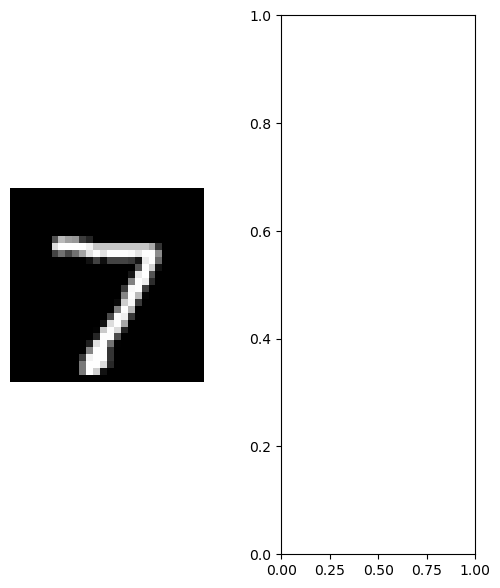

In [30]:
# Shows the image next to the classifier's softmax score
# Show for the first 10 images (change value to see more images)
for i in range(10):
    helpers.view_prediction(images[i], preds[i], test_data.classes)

Not bad, right?

Congratulations on finishing this exercise! If you want to try out your network on a different dataset, take a look at part 6.

Next week, we'll take a look at convolutional neural networks, which can do even better than these fully-connected neural networks on image datasets. See you then!

## 6. (Optional) Training your model on a different dataset
There are many datasets designed to serve as a direct drop-in replacement to MNIST, one of them being [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), by Zalando Research.

You can try out these two networks on Fashion-MNIST by just replacing the following two lines at the beginning of the notebook and re-running the entire code.

Replace:
```python
train_data = MNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = MNIST(root, train=False, transform=transforms.ToTensor(), download=True)
```

with:
```python
train_data = FashionMNIST(root, train=True, transform=transforms.ToTensor(), download=True)
test_data = FashionMNIST(root, train=False, transform=transforms.ToTensor(), download=True)
```

**Note:** FashionMNIST is a harder dataset than MNIST, so your accuracy will likely be lower.

## Additional PyTorch resources
- PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html
- Other PyTorch tutorials: https://pytorch.org/tutorials/index.html
- PyTorch recipes: https://pytorch.org/tutorials/recipes/recipes_index.html (bite-sized code examples on specific PyTorch features)
- PyTorch examples: https://github.com/pytorch/examples